<a href="https://colab.research.google.com/github/PerifanosPrometheus/GiorgioDiSalvo/blob/master/Copy_of_Table1_spherical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spherical clustering of DCSBM

This Notebook attempts to compare the ARI obtained by fitting Gaussian mixture models(GMM) to the latent positions obtained from Adjacency spectral embedding of DCSBM graphs versus fitting GMM to the same latent positions but expressed in spherical coordinates as described by [Passino et al.](https://arxiv.org/pdf/2011.04558.pdf). 


Synthetic data will be simulated by sampling undirected graphs from degree-corrected stochastic blockmodels(DCSBM) with a fixed number of communities $K=3$. Each graph is simulated by randomly selecting $B \sim Uniform(0, 1)^{K×K}$ and sampling the degree correction parameters
$\rho_i \sim Beta(2, 1)$.

### Import

Let's first import relevant packages

In [ ]:
#! /usr/bin/env python3
import numpy as np
from numpy.random import normal, poisson
import argparse
from collections import Counter
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import scale
from scipy.stats import chi2, norm
from sklearn.metrics import adjusted_rand_score as ari
!pip install graspologic
import graspologic
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.cluster import AutoGMMCluster
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



## Function converting cartesian to spherical coordinates

Let's no define a function to perform transformation of coordinates.

In [ ]:
#Code provided by Passino et al.
## Takes a vector and returns its spherical coordinates
def cart_to_sphere(x):
    ## theta_1
    q = np.arccos(x[1] / np.linalg.norm(x[:2]))
    sphere_coord = [q] if x[0] >= 0 else [2*np.pi - q]
    ## Loop for theta_2, ..., theta_m-1
    for j in range(2,len(x)):
      sphere_coord += [2 * np.arccos(x[j] / np.linalg.norm(x[:(j+1)]))]
    ## Return the result in a numpy array
    return np.array(sphere_coord)

## Takes a matrix and returns the spherical coordinates obtained along the given axis
def theta_transform(X,axis=1):
    ## Apply the function theta_transform along the axis
    return np.apply_along_axis(func1d=cart_to_sphere, axis=axis, arr=X)

# Function to plot histograms of latent positions

In [ ]:
def simple_scatter(X, ax, y=None, title = None):
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        s=15,
        linewidth=0.25,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    ax.set(xticks=[-0.6, 0.1], yticks=[-0.5, 0.5], xlabel=r"$\mathbf{X}_1$", ylabel=r"$\mathbf{X}_2$", xlim=(-1, 1), ylim=(-1, 1), title=r"$\hat\mathbf{X}$")
    ax.set_title(title)

# Visual intuition

Let's first develop a simple visual intuition.

Here we simulate a graph $G\sim DCSBM$ with the following parameters:

$n = 500\\
K=2\\
\rho_{i}\sim Beta(2,1)\\
B = \begin{bmatrix}0.1 & 0.05\\
0.05 & 0.15 \end{bmatrix}$

We then perform Adjacency Spectral Embedding and to obtain the latent positions $X$. We will also compute $\bar X$ as the normalized latent positions for $X$ and $\Theta$ as representation of $X$ in spherical coordinates on the unit sphere. 

Finally we plot the histograms for $X$,$\bar X$, and $\Theta$.

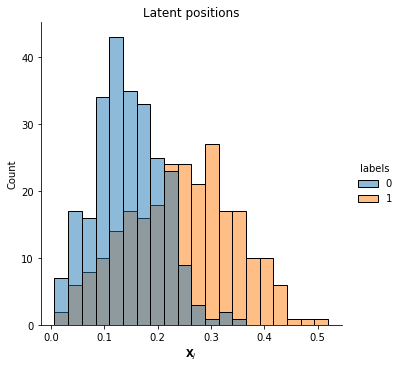

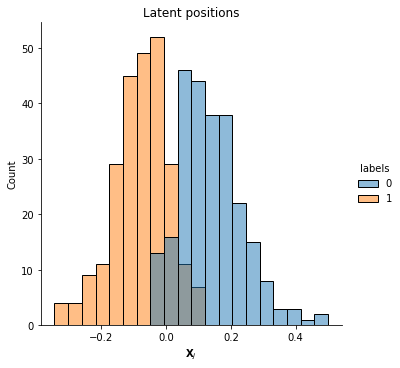

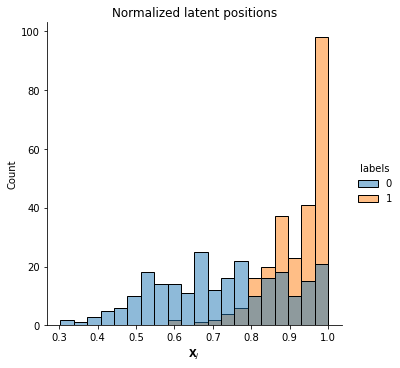

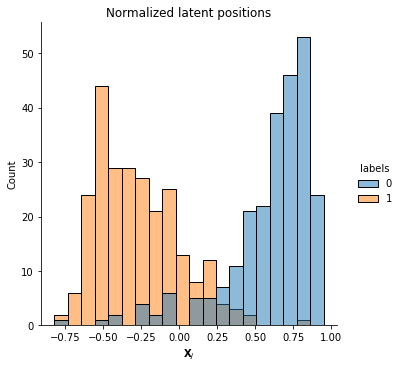

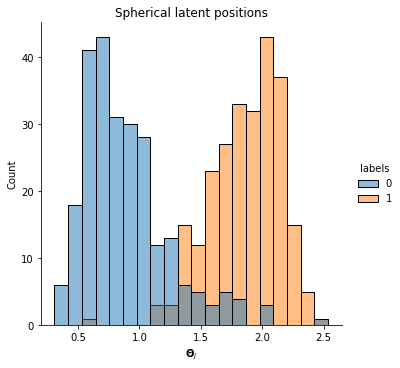

In [ ]:
#use jointplot from sns https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot to create plots, much simpler and more appealing 

K = 2
n = 500

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

B = np.vstack(([0.1,0.05],[0.05,0.15]))

rho = np.random.beta(a=2,b=1,size=n)
## Construct the adjacency matrix
A = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
        A[i,j] = edge
        A[j,i] = edge

## Obtain the embeddings
ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
X = ase.fit_transform(A)

#removes latent positions made up only by zeros
idx_zerorows = np.where(~X.any(axis=1))
X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
zz = np.delete(z, idx_zerorows, 0) 

for t in [None, 'normalised', 'theta']:
  if t == 'normalised':
      for j in range(normalize(X).shape[1]):
        x_hist = {r"$\mathbf{X}_j$": normalize(X)[:, j], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.displot(data=x_hist, x=r"$\mathbf{X}_j$", hue="labels", bins = 20)
        plt.title("Normalized latent positions")
  elif t == 'theta':
      for j in range(theta_transform(X).shape[1]):
        x_hist = {r"$\mathbf{\Theta}_j$": theta_transform(X)[:, j], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.displot(data=x_hist, x=r"$\mathbf{\Theta}_j$", hue="labels", bins = 20)
        plt.title("Spherical latent positions")
  else: 
      for j in range(X.shape[1]):
        x_hist = {r"$\mathbf{X}_j$": X[:, j], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.displot(data=x_hist, x=r"$\mathbf{X}_j$", hue="labels", bins = 20)
        plt.title("Latent positions")

As we can see, in the first histograms labeled spectral embeddings, which represent the embedding $X$,and in the histogram of the row-normalized $\bar X$ we see that there is little separation for the two communities in one of the two embedding dimensions. 

On the other hand, if we look at the representation in spherical coordinates $\Theta$ we can see a much clearer separation between the latent positions. 

# ARI comparison for $n=500$ number of nodes

We now simulate $N=50$ undirected graphs from degree-corrected stochastic blockmodels(DCSBM) with a fixed number of communities $K=3$. Each graph has $n=500$ nodes and is simulated by randomly selecting $B \sim Uniform(0, 1)^{K×K}$ and sampling the degree correction parameters
$\rho_i \sim Beta(2, 1)$.

We then compute the embedding $X$, the row-normalized embedding $\bar X$ and the spherical coordinates representation of the embedding $\Theta$ on the unit sphere.

$N = 50,K=3\\
| G_i | = 500\\
G_i \sim DCSBM(B_i, \rho_{ij}) \text{for }i= 1,2,...,N \\
B_i \sim Uniform(0, 1)^{K×K}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 500
M_sim = 50

K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com = []
n_com_norm = []
n_com_theta = []

ari_com = []
ari_com_norm = []
ari_com_theta = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.tril(np.random.uniform(size=(K,K)))
    B += np.tril(B,k=-1).T

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm.append(M.n_components_)
          ari_com_norm.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta.append(M.n_components_)
          ari_com_theta.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com.append(M.n_components_)
          ari_com.append(M.ari_)

    if (ari_com_1000[-1]>ari_com_theta_1000[-1]):
      print("Cartesian better for B = ", B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Plot ARI and estimated number of communities

Let's plot the ARI obtained at each iteration.

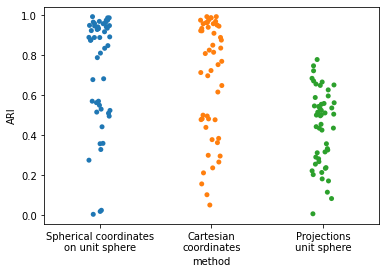

In [ ]:
ARI = {"ARI": ari_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com)+1)}
ARI_norm =  {"ARI": ari_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm)+1)}
ARI_theta = { "ARI": ari_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

Let's plot the number of communities estimated by GMM with best BIC/AIC scores

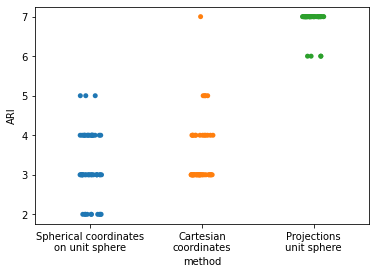

In [ ]:
N_COM = {"ARI": n_com, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com)+1)}
N_COM_norm =  {"ARI": n_com_norm, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm)+1)}
N_COM_theta = { "ARI": n_com_theta, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

# Average ARI per method

Let's first check the average ARI obtained by applying the GMM using the three different methods

In [ ]:
print(np.mean(ari_com))
print(np.std(ari_com))

0.6843354311447737
0.2850285039219778


In [ ]:
print(np.mean(ari_com_norm))
print(np.std(ari_com_norm))

0.4417084436293726
0.18744015351248372


In [ ]:
print(np.mean(ari_com_theta))
print(np.std(ari_com_theta))

0.7334426761561131
0.27734618000399075


# ARI comparison for $n=1000$ number of nodes

We now repeat previous experiment, this time generating $N=25$ graphs with $n=1000$ nodes and same parameters.

$N = 25,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B_i, \rho_{ij}) \text{for }i= 1,2,...,N \\
B_i \sim Uniform(0, 1)^{K×K}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 1000
#M_sim = 25 Use 25 to produce plot for experiment
M_sim = 25 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.tril(np.random.uniform(size=(K,K)))
    B += np.tril(B,k=-1).T

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

    if (ari_com_1000[-1]>ari_com_theta_1000[-1]):
      print("Cartesian better for B = ", B)

0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24


# Plot ARI and estimated number of communities

Let's plot the ARI obtained at each iteration.

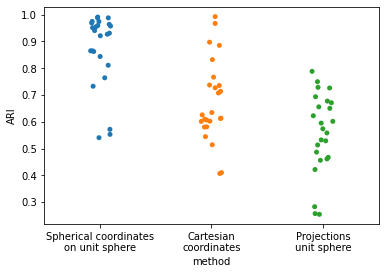

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

Let's plot the number of communities estimated by GMM with best BIC/AIC scores

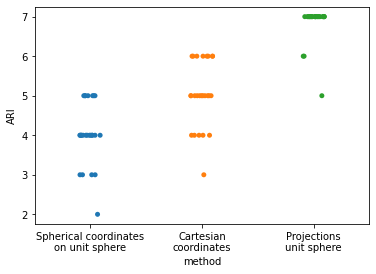

In [ ]:
N_COM = {"ARI": n_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM_norm =  {"ARI": n_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm_1000)+1)}
N_COM_theta = { "ARI": n_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta_1000)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

# Average ARI per method

In [ ]:
print(np.mean(ari_com_1000))
print(np.std(ari_com_1000))

0.6760333040025759
0.14969072754925553


In [ ]:
print(np.mean(ari_com_norm_1000))
print(np.std(ari_com_norm_1000))

0.5580032617045139
0.1458888249518584


In [ ]:
print(np.mean(ari_com_theta_1000))
print(np.std(ari_com_theta_1000))

0.8719632757947999
0.13555939073679296


#Experiment with fixed B(not sparse, positive definite)

$N = 50,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho_{ij}) \text{for }i= 1,2,...,N \\
B = \begin{bmatrix} 0.8 & 0.7 & 0.45\\ 0.6 & 0.5 & 0.1 \\ 0.15 & 0.2 & 0.3\end{bmatrix}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 1000
M_sim = 50 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)

    B = np.vstack(([0.8, 0.7, 0.45],
                   [0.6, 0.5, 0.1],
                   [0.15, 0.2, 0.3]))

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


#Plot results

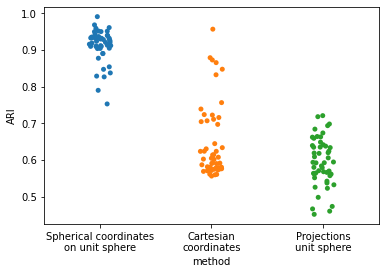

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

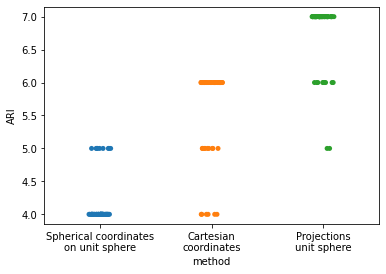

In [ ]:
N_COM = {"ARI": n_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM_norm =  {"ARI": n_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm_1000)+1)}
N_COM_theta = { "ARI": n_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta_1000)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

# Experiment with fixed B(not sparse, negative definite)

$N = 25,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho_{ij}) \text{for }i= 1,2,...,N \\
B = \begin{bmatrix} 0.05 & 0.75 & 0.95\\ 0.65 & 0.25 & 0.9 \\ 0.85 & 0.55 & 0.45\end{bmatrix}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 1000
M_sim = 25 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)

    B = np.vstack(([0.05, 0.75, 0.95],
              [0.65, 0.25, 0.90],
              [0.85, 0.55, 0.45]))

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


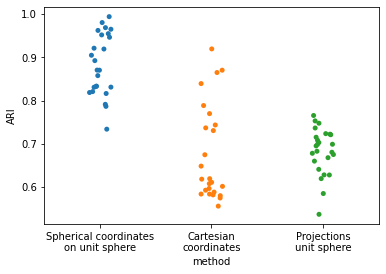

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

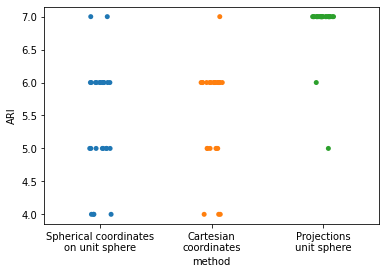

In [ ]:
N_COM = {"ARI": n_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM_norm =  {"ARI": n_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm_1000)+1)}
N_COM_theta = { "ARI": n_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta_1000)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

#Experiment with fixed B(sparse, positive definite)

$N = 25,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho_{ij}) \text{for }i= 1,2,...,N \\
sparse\_scaler = 10\\
B = \frac{1}{sparse\_scaler}\begin{bmatrix} 0.8 & 0.7 & 0.45\\ 0.6 & 0.5 & 0.1 \\ 0.15 & 0.2 & 0.3\end{bmatrix}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 1000
M_sim = 25 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

sparse_scaler = 10

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)

    B = np.vstack(([0.8, 0.7, 0.45],
                   [0.6, 0.5, 0.1],
                   [0.15, 0.2, 0.3]))

    B = B / sparse_scaler

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

In [ ]:
N_COM = {"ARI": n_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM_norm =  {"ARI": n_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm_1000)+1)}
N_COM_theta = { "ARI": n_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta_1000)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

# Experiment with fixed B(sparse, negative definite)

$N = 25,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho_{ij}) \text{for }i= 1,2,...,N \\
sparse\_scaler = 10\\
B = \frac{1}{sparse\_scaler}\begin{bmatrix} 0.05 & 0.75 & 0.95\\ 0.65 & 0.25 & 0.9 \\ 0.85 & 0.55 & 0.45\end{bmatrix}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 1000
M_sim = 25 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)

    B = np.vstack(([0.05, 0.75, 0.95],
                   [0.65, 0.25, 0.90],
                   [0.85, 0.55, 0.45]))

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

In [ ]:
N_COM = {"ARI": n_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM_norm =  {"ARI": n_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm_1000)+1)}
N_COM_theta = { "ARI": n_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta_1000)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

# B is diagonal

$N = 25,K=3\\
| G_i | = 1000\\
G_i \sim DCSBM(B, \rho_{ij}) \text{for }i= 1,2,...,N \\
B = \begin{bmatrix} 0.9 & 0 & 0\\ 0 & 0.5 & 0 \\ 0 & 0 & 0.2\end{bmatrix}\\
\rho_{ij} \sim Beta(2, 1)$

In [ ]:
## Arguments
n = 1000
M_sim = 25 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)

    B = np.vstack(([0.9, 0.0, 0.0],
                   [0.0, 0.5, 0.0],
                   [0.0, 0.0, 0.2]))


    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)

In [ ]:
N_COM = {"ARI": n_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM_norm =  {"ARI": n_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(n_com_norm_1000)+1)}
N_COM_theta = { "ARI": n_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(n_com_theta_1000)+1)}

N_COM = pd.DataFrame(data=N_COM)
N_COM_norm = pd.DataFrame(data=N_COM_norm)
N_COM_theta = pd.DataFrame(data=N_COM_theta)
N_COM = pd.concat([N_COM_theta, N_COM, N_COM_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=N_COM)

# Figure out other experiments

- vary degree correction parameters distribution

Varying sampling distributions of degree correction parameters

In [ ]:
## Arguments
n = 900
M_sim = 10 # used to have some quick results to plot 
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k
B = np.vstack(([0.6, 0.4, 0.2],
               [0.4, 0.5, 0.4],
               [0.2, 0.4, 0.4]))

wt = [[normal, poisson, poisson],
      [poisson, normal, poisson],
      [poisson, poisson, normal]]
wtargs = [[dict(loc=3, scale=1), dict(lam=5), dict(lam=3)],
          [dict(lam=5), dict(loc=3, scale=1), dict(lam=4)],
          [dict(lam=3),  dict(lam=4), dict(loc=3, scale=1)]]

community_sizes = [n // 3, n // 3, n // 3]

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)

    ## Construct the adjacency matrix
    A = sbm(n=community_sizes, p=B, wt=wt, wtargs=wtargs)

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

0
1
2
3
4
5
6
7
8
9


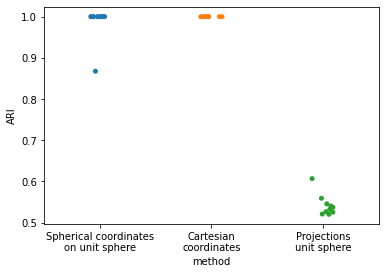

In [ ]:
ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

ARI = pd.DataFrame(data=ARI)
ARI_norm = pd.DataFrame(data=ARI_norm)
ARI_theta = pd.DataFrame(data=ARI_theta)
ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

ax = sns.stripplot(x="method", y="ARI", data=ARI)